Advanced lane finding
==================

Imports
---------

In [145]:
import os
import math
import cv2
import time
import copy
import numpy as np
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Constants
---------

In [96]:
WARPED_WIDTH = 500
WARPED_HEIGHT = 500
WARPED_POINTS = np.array([
    [WARPED_WIDTH * 0, WARPED_HEIGHT - 1],
    [WARPED_WIDTH * 0, 0],
    [WARPED_WIDTH - 1, 0],
    [WARPED_WIDTH - 1, WARPED_HEIGHT - 1],
], dtype=np.float32)

THRESHOLD_EDGE = 0.15

WINDOWS_N = 10
WINDOW_HEIGHT = int(WARPED_HEIGHT / float(WINDOWS_N))
WINDOW_WIDTH = int(WARPED_WIDTH * 0.08)
WINDOW_WIDTH = WINDOW_WIDTH + (WINDOW_WIDTH % 2)
HALF_WINDOW_WIDTH = int(WINDOW_WIDTH / 2)        
DEBUG_DIVIDER_WIDTH = 4

PIXELS_TO_METERS_Y = 3.0 / 100
PIXELS_TO_METERS_X = 3.7 / 350

Utility functions
-----------------

In [122]:
## Region of interest
def build_region_of_interest(shape):
    height = shape[0]
    width = shape[1]
    return np.array([[
        [width * 0.0, height - 1],
        [width * 0.415, height * 0.65],
        [width * 0.585, height * 0.65],
        [width - 1, height - 1],
    ]], dtype=np.int32)

def display_image(image, cmap = None, figsize = None):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)

def read_image(location):
    return mpimg.imread(location)

## Add an image to a debug output that contains multiple images: 
## top row: warped image, edge filter output, color filter output, edge+color filter combined output + windows
## bottom row: original image+lines
def add_to_debug_image(img, state, row=0):
    if (state.is_debug):
        # TODO revise this
        if (np.max(img) <= 1):
            img = img * 255
        
        if (row==0):
            left_offset = state.debug_left_pos
            top_offset = 0
        else:
            left_offset = 0
            top_offset = WARPED_HEIGHT
        
        # draw image depending on the number of channels
        if (len(img.shape) == 3 and img.shape[2] == 3):
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1]] = img
        else:
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1], 0] = img
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1], 1] = img
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1], 2] = img

        if (row==0):
            state.debug_left_pos += img.shape[1]
            # add divider
            state.debug_image[0:img.shape[0], state.debug_left_pos:state.debug_left_pos + DEBUG_DIVIDER_WIDTH] = 255
            state.debug_left_pos += DEBUG_DIVIDER_WIDTH
            
test_image = read_image('test_images/test6.jpg')
test_state = None
debug_state = None
def get_test_state():
    global test_state
    if (test_state is None):
        test_state = State(test_image)
    return test_state

def get_debug_state():
    global debug_state
    if (debug_state is None):
        debug_state = State(test_image, True)
    return debug_state

Curve class
-----------

In [139]:
class Curve:
    a = None
    b = None
    c = None
    weight = 0
    radius = None
    
    def get_curve_radius(self):
        y_m = WARPED_HEIGHT * PIXELS_TO_METERS_Y
        A_m = self.a * PIXELS_TO_METERS_X / (PIXELS_TO_METERS_Y ** 2)
        B_m = self.b * PIXELS_TO_METERS_X / PIXELS_TO_METERS_Y

        radius = ((1 + (2 * A_m * y_m + B_m) ** 2) ** (1.5)) / abs(2 * A_m)
        return radius
        
    def __init__(self, coeffs_array, weight=0):
        self.a = coeffs_array[0]
        self.b = coeffs_array[1]
        self.c = coeffs_array[2]
        self.weight = weight
        self.radius = self.get_curve_radius()

State class
-----------

In [121]:
class State:
    is_debug_image = None
    is_debug_video = None
    is_debug=None
    # distortion
    distortion_coefficients = None
    camera_matrix = None
    # warping
    region_of_interest = None
    warp_matrix = None
    unwarp_matrix = None
    # dimensions
    height_orig = None
    width_orig = None
    # windows
    conv_kernel = None
    # line finding
    windows = None
    # curves
    curves = None
    curve_points_num = None
    
    debug_image = None
    debug_left_pos = 0
    
    def __init__(self, img, is_debug_image=False, is_debug_video=False):
        self.camera_matrix, self.distortion_coefficients = get_calibration_parameters()
        self.height_orig = img.shape[0]
        self.width_orig = img.shape[1]
        self.region_of_interest = build_region_of_interest(img.shape[0:2])
        self.conv_kernel = get_conv_kernel(WARPED_WIDTH)
        self.warp_matrix = get_warp_matrix(self.region_of_interest)
        self.unwarp_matrix = get_unwarp_matrix(self.region_of_interest)
        self.is_debug_video = is_debug_video
        self.is_debug_image = is_debug_image
        self.is_debug = self.is_debug_video or self.is_debug_image
        self.curve_points_num = { 'left':0, 'right':0 }
        self.curves = { 'left': None, 'right': None }
        if (self.is_debug):
            self.debug_image = np.zeros((
                self.height_orig + WARPED_HEIGHT, 
                max(self.width_orig, (WARPED_WIDTH+DEBUG_DIVIDER_WIDTH) * 4),
                3
            ))

Camera calibration and undistortion
------------------------------------------

In [28]:
def init_calibration_parameters():
    # termination criteria for cv2.cornerSubPix()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)    
    
    cal_images = os.listdir("./camera_cal")
    cal_columns = 9
    cal_rows = 6
    obj_points = []
    img_points = []
    obj_points_batch = np.zeros((cal_rows * cal_columns, 3), np.float32)
    obj_points_batch[:,:2] = np.mgrid[0:cal_columns, 0:cal_rows].T.reshape(-1, 2)
    gray = None
    for i, file_name in enumerate(cal_images):
        img = read_image('./camera_cal/' + file_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        is_found, corners = cv2.findChessboardCorners(gray, (cal_columns, cal_rows))
        if (is_found):
            corners = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)          
            obj_points.append(obj_points_batch)
            img_points.append(corners.astype('float32'))
            
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, gray.shape[::-1], None, None)
    return cameraMatrix, distCoeffs

camera_matrix = None 
dist_coeffs = None
def get_calibration_parameters():
    global camera_matrix
    global dist_coeffs
    if (camera_matrix is None or dist_coeffs is None):
        camera_matrix, dist_coeffs = init_calibration_parameters()
    return camera_matrix, dist_coeffs

def undistort(img, state):
    img_undistorted = cv2.undistort(
        img, 
        state.camera_matrix, 
        state.distortion_coefficients, 
        None, 
        state.camera_matrix
    )
    return img_undistorted

# Test
#
# img = read_image('./camera_cal/calibration5.jpg')
# state = get_test_state()
# display_image(img)
# und_img = undistort(img, state)
# display_image(und_img)

Warping
----------

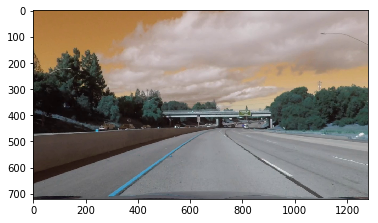

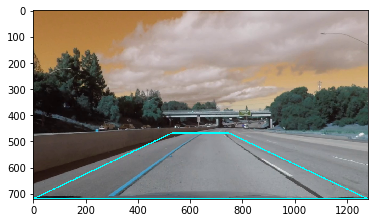

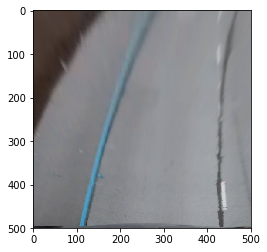

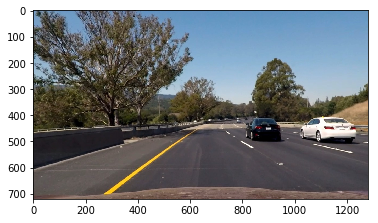

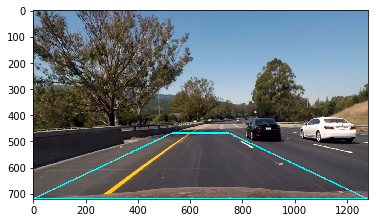

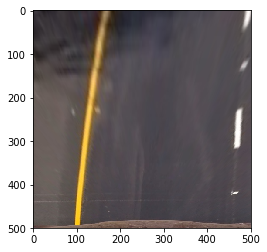

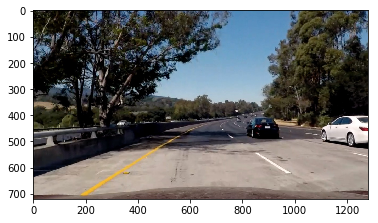

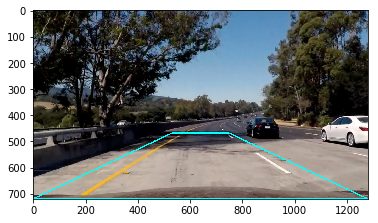

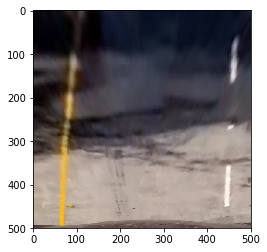

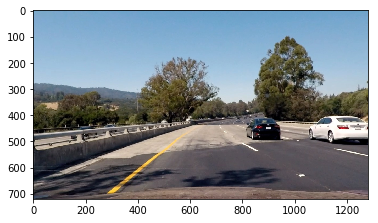

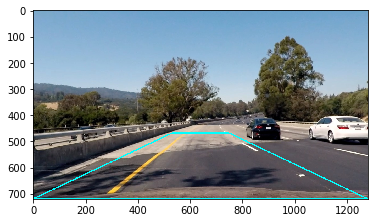

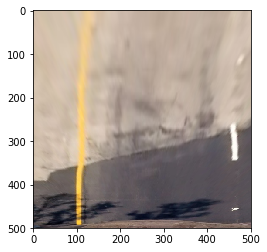

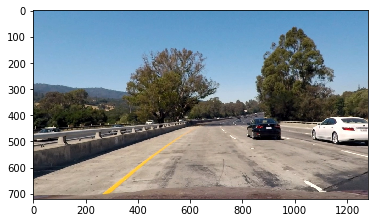

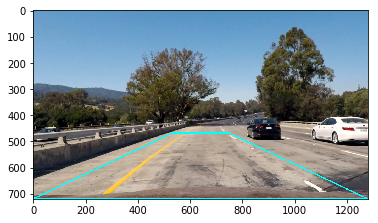

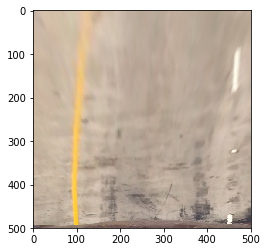

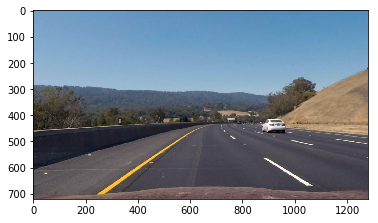

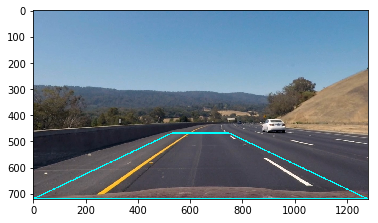

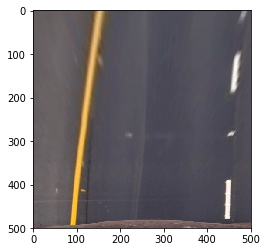

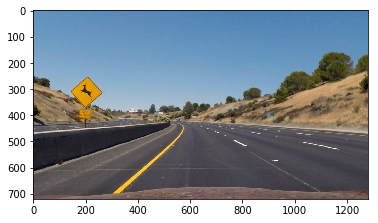

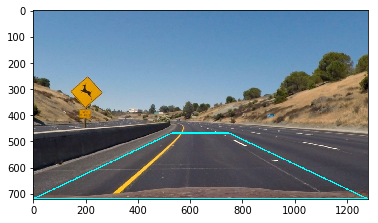

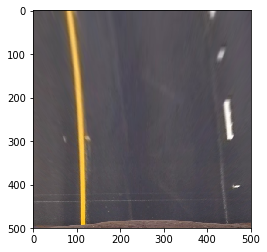

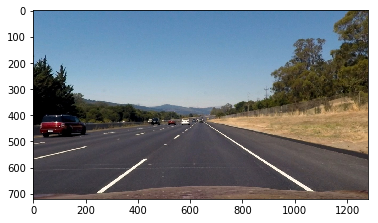

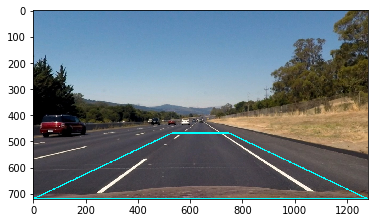

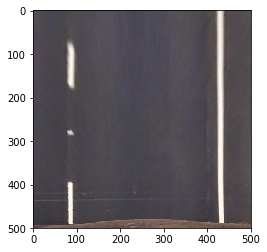

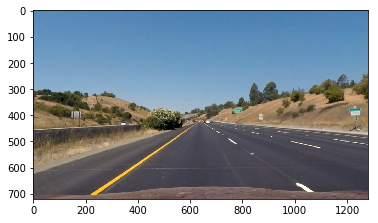

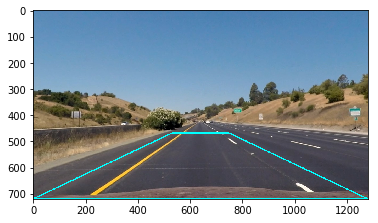

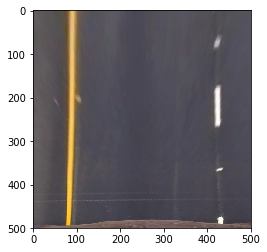

In [67]:
def get_warp_matrix(region_of_interest):
    M = cv2.getPerspectiveTransform(np.array(region_of_interest[0], dtype=np.float32), WARPED_POINTS)
    return M

def get_unwarp_matrix(region_of_interest):
    M = cv2.getPerspectiveTransform(WARPED_POINTS, np.array(region_of_interest[0], dtype=np.float32))
    return M

def warp(img, state):
    warped_image = cv2.warpPerspective(img, state.warp_matrix, (WARPED_WIDTH, WARPED_HEIGHT))
    add_to_debug_image(warped_image, state)
    return warped_image
    
def unwarp(img, state):
    unwarped_image = cv2.warpPerspective(img, state.unwarp_matrix, (state.width_orig, state.height_orig))
    return unwarped_image
    
def test_undistort_and_warp(img, state):
    img_undistorted = undistort(img, state)
    display_image(img_undistorted)
    img_regions = cv2.polylines(img_undistorted.copy(), state.region_of_interest, True, (0, 255, 255), thickness = 3)
    display_image(img_regions)
    img_warped = warp(img_undistorted, state)
    display_image(img_warped)
    
# Test

img = read_image('./camera_cal/calibration5.jpg')
state = get_test_state()    
for i, file_name in enumerate(os.listdir("./test_images")):
    if (file_name.endswith(".jpg")):
        test_undistort_and_warp(read_image("./test_images/" + file_name), state)

Edges
-------

img_from_video_0.jpg
test6.jpg
test5.jpg
test4.jpg
test1.jpg
test3.jpg
test2.jpg
straight_lines2.jpg
straight_lines1.jpg


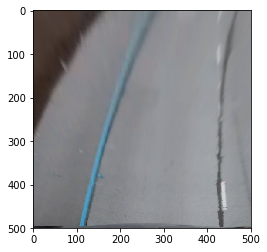

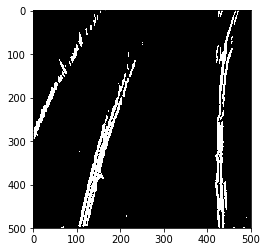

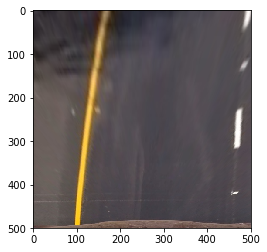

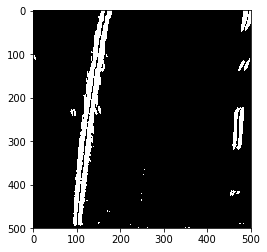

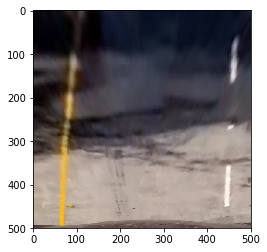

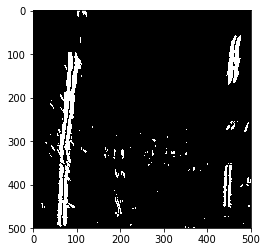

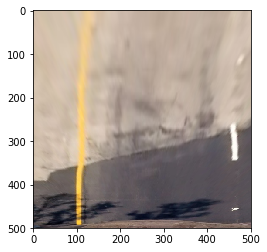

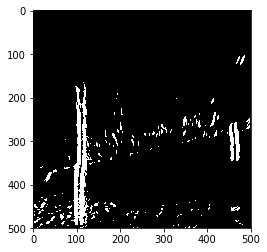

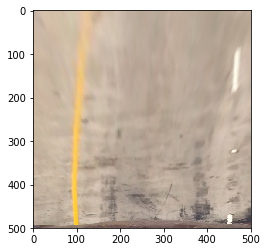

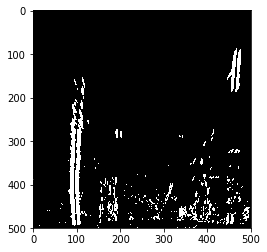

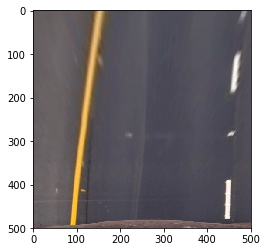

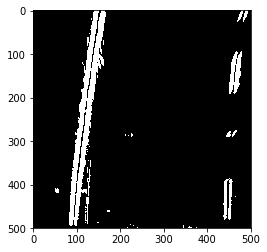

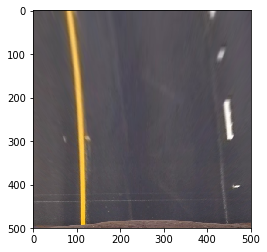

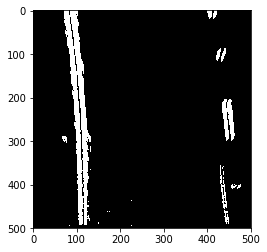

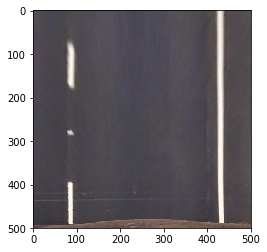

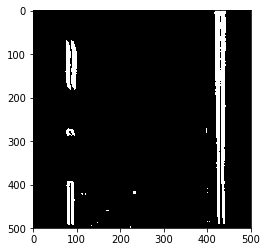

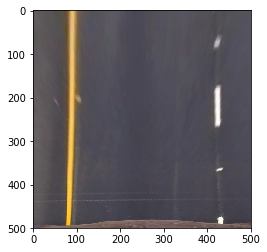

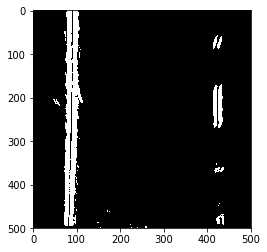

In [131]:
THRESHOLD_EDGE = 0.05
def get_binary_image_with_edge_pixels(img, state):
    MAX_EDGE_VALUE = 163200.0 # cv2.getDerivKernels()&np.outer()
    ## Sobel
    abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=7))
    one_layer = np.max(abs_sobel, axis=2)
    img_sobel = one_layer / MAX_EDGE_VALUE
    img_binary = np.zeros_like(img_sobel)
    img_binary[img_sobel > THRESHOLD_EDGE] = 1
#     add_to_debug_image(img_binary, state)
    return img_binary

def test_get_binary_image_with_edge_pixels(img):
    # preparation
    state = get_test_state()
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    display_image(img_warped)
    display_image(get_binary_image_with_edge_pixels(img_warped, state), cmap='gray')

# Test
#
for i, file_name in enumerate(os.listdir("./test_images")):
    if (file_name.endswith(".jpg")):
        print(file_name)
        test_get_binary_image_with_edge_pixels(read_image("./test_images/" + file_name))

White line
----------

img_from_video_0.jpg
test6.jpg
test5.jpg
test4.jpg
test1.jpg
test3.jpg
test2.jpg
straight_lines2.jpg
straight_lines1.jpg


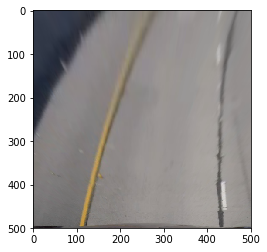

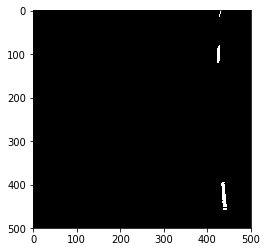

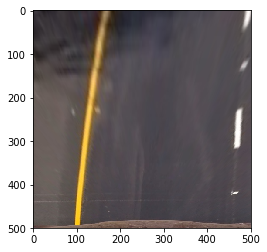

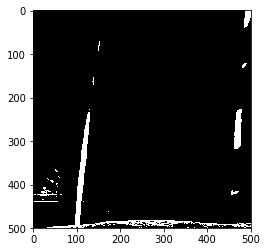

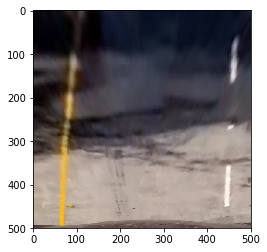

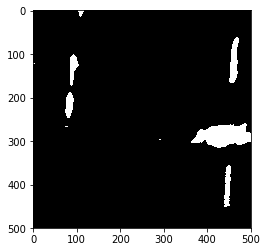

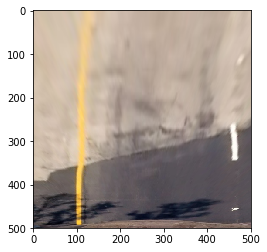

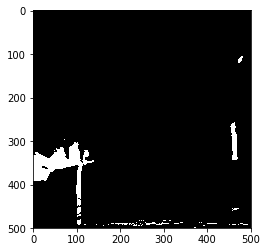

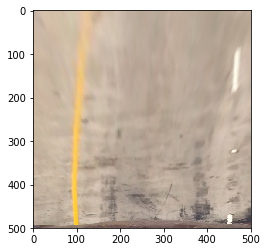

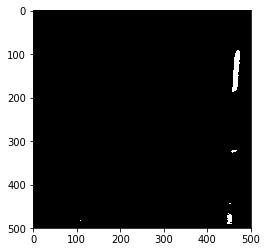

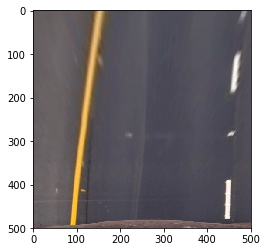

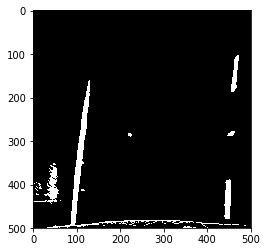

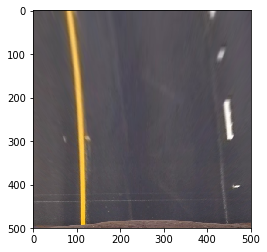

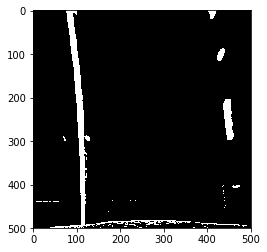

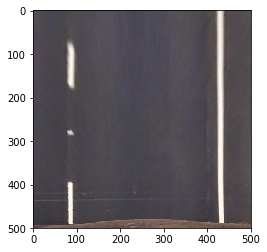

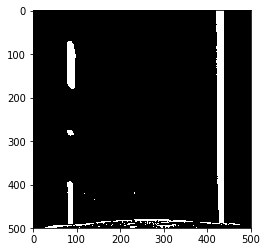

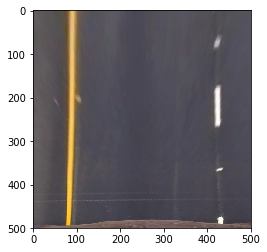

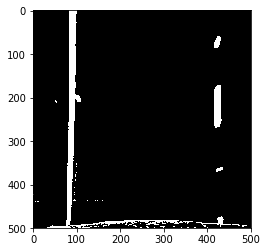

In [31]:
def get_white_line_signals(img, state):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    CONVOLUTION_SIZE = int(WARPED_WIDTH / 5)
    conv_vector = np.ones(CONVOLUTION_SIZE) / CONVOLUTION_SIZE
    light_matrix = img_hls[:, :, 1]
    center_light_matrix = light_matrix[:, int(WARPED_WIDTH / 4):int(WARPED_WIDTH * 3 / 4)]
    average_light_vector = np.percentile(center_light_matrix, 98, axis=1)
    convolved_vector = np.convolve(average_light_vector, conv_vector, 'valid')
    # pad with edge averages
    uncovered_area_size = WARPED_HEIGHT - len(convolved_vector)
    convolved_vector = np.concatenate((
        np.ones((int(uncovered_area_size / 2))) * convolved_vector[0],
        convolved_vector,
        np.ones((uncovered_area_size - int(uncovered_area_size / 2))) * convolved_vector[-1],
    ))
    
    convolved_matrix = np.dot(
        convolved_vector.reshape((WARPED_HEIGHT, 1)), 
        np.ones((WARPED_WIDTH)).reshape((1, WARPED_WIDTH))
    )
    
    binary = np.zeros_like(light_matrix)
    binary[light_matrix > convolved_matrix + 20] = 1
    
    return binary

def test_get_white_line_signals(img):
    img = read_image("./test_images/" + file_name)
    state = get_test_state()
    
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    if (file_name.startswith('img_from_video_0')):
        img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
    display_image(img_warped)
    binary_image = get_white_line_signals(img_warped, state)
    display_image(binary_image, cmap='gray')

# test_get_white_line_signals(read_image("./test_images/img_from_video_0.jpg"))

files = os.listdir("./test_images")
for i, file_name in enumerate(files):
    if (file_name.endswith(".jpg")):
        print(file_name)
        test_get_white_line_signals(file_name)

Yellow line
------------

In [32]:
# def get_binary_image_with_color_pixels(img, state):
#     img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#     binary_h = np.zeros_like(img_hls[:,:,0])
#     binary_l = np.zeros_like(binary_h)
#     binary_s = np.zeros_like(binary_h)
#     binary_h[np.all([15 <= img_hls[:,:,0], img_hls[:,:,0] <= 45], axis=0)] = 1
    
    
    
#     CONVOLUTION_SIZE = int(WARPED_WIDTH / 5)
#     conv_vector = np.ones(CONVOLUTION_SIZE) / CONVOLUTION_SIZE
#     light_matrix = img_hls[:, :, 1]
#     center_light_matrix = light_matrix[:, int(WARPED_WIDTH / 4):int(WARPED_WIDTH * 3 / 4)]
#     average_light_vector = np.percentile(center_light_matrix, 0.8, axis=1)
#     max_light_vector = np.max(center_light_matrix, axis=1)
#     convolved_vector = np.convolve(average_light_vector, conv_vector, 'valid')
#     # pad with edge averages
#     uncovered_area_size = WARPED_HEIGHT - len(convolved_vector)
#     convolved_vector = np.concatenate((
#         np.ones((int(uncovered_area_size / 2))) * convolved_vector[0],
#         convolved_vector,
#         np.ones((uncovered_area_size - int(uncovered_area_size / 2))) * convolved_vector[-1],
#     ))
    
#     convolved_matrix = np.dot(
#         convolved_vector.reshape((WARPED_HEIGHT, 1)), 
#         np.ones((WARPED_WIDTH)).reshape((1, WARPED_WIDTH))
#     )
    
#     binary = np.zeros_like(light_matrix)
# #     binary[light_matrix > convolved_matrix * 1.1 + 25] = 1

#     binary[light_matrix > convolved_matrix] = 1
    
#     return binary

# def test_get_white_line_signals(img):
#     state = get_test_state()
    
#     img_undistorted = undistort(img, state)
#     img_warped = warp(img_undistorted, state)
#     img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
#     display_image(img_warped)
#     binary_image = get_white_line_signals(img_warped, state)
#     display_image(binary_image, cmap='gray')

# # test_get_white_line_signals(read_image("./test_images/img_from_video_0.jpg"))

# files = os.listdir("./test_images")
# for i, file_name in enumerate(files):
#     if (file_name.endswith(".jpg")):
#         print(file_name)
#         test_get_white_line_signals(read_image("./test_images/" + file_name))

img_from_video_0.jpg
test6.jpg
test5.jpg
test4.jpg
test1.jpg
test3.jpg
test2.jpg
straight_lines2.jpg
straight_lines1.jpg


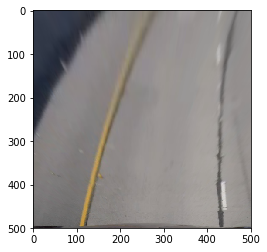

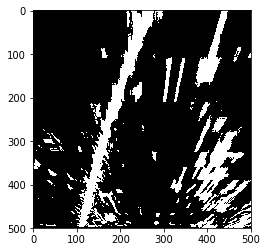

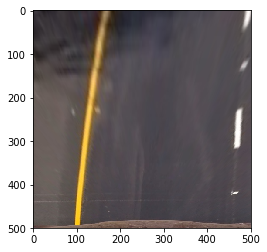

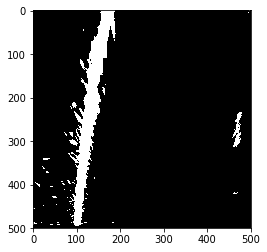

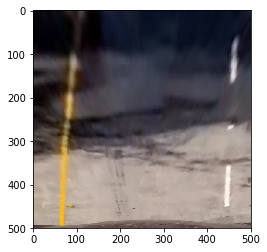

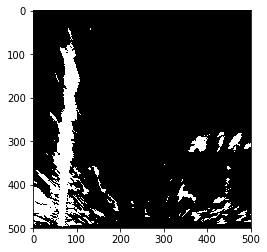

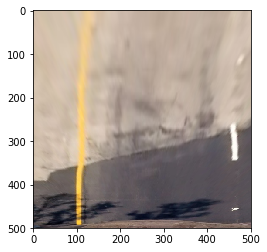

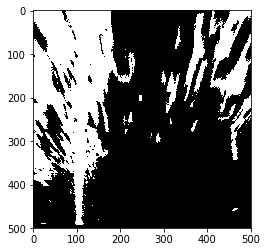

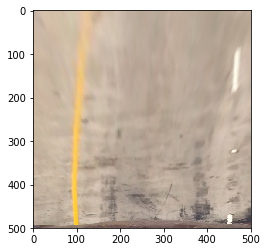

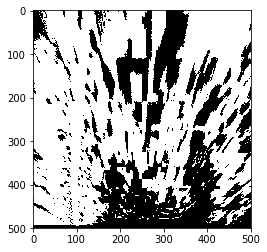

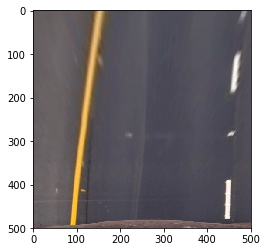

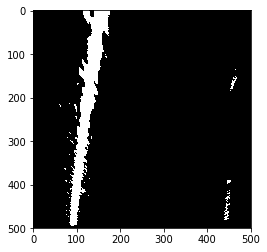

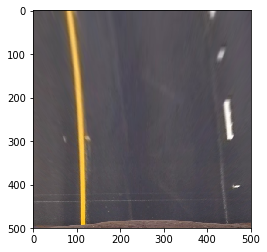

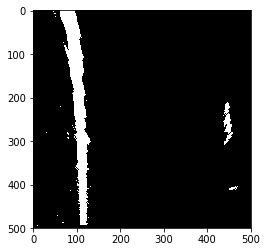

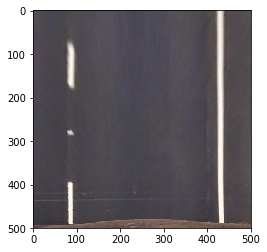

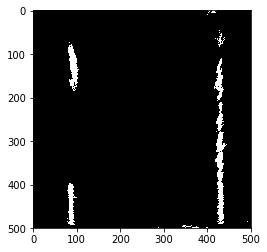

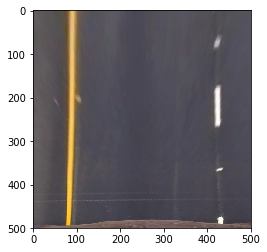

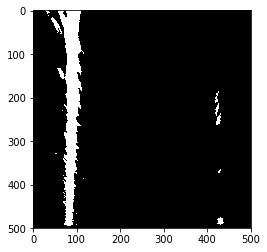

In [33]:
def get_binary_image_with_color_pixels(img, state):
#     img_blur = np.uint8(cv2.GaussianBlur(img, (3,3), 0))
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_h = np.zeros_like(img_hls[:,:,0])
    binary_h[np.all([15 <= img_hls[:,:,0], img_hls[:,:,0] <= 40], axis=0)] = 1
    
#     light_matrix = img_hls[:, :, 1]
#     CONVOLUTION_SIZE = int(WARPED_WIDTH / 5)
#     conv_vector = np.ones(CONVOLUTION_SIZE) / CONVOLUTION_SIZE
#     center_light_matrix = light_matrix[:, int(WARPED_WIDTH / 4):int(WARPED_WIDTH * 3 / 4)]
#     average_light_vector = np.percentile(center_light_matrix, 0, axis=1)
#     convolved_vector = np.convolve(average_light_vector, conv_vector, 'valid')
#     # pad with edge averages
#     uncovered_area_size = WARPED_HEIGHT - len(convolved_vector)
#     convolved_vector = np.concatenate((
#         np.ones((int(uncovered_area_size / 2))) * convolved_vector[0],
#         convolved_vector,
#         np.ones((uncovered_area_size - int(uncovered_area_size / 2))) * convolved_vector[-1],
#     ))
#     convolved_matrix = np.dot(
#         convolved_vector.reshape((WARPED_HEIGHT, 1)), 
#         np.ones((WARPED_WIDTH)).reshape((1, WARPED_WIDTH))
#     )
    
#     binary = np.zeros_like(light_matrix)
#     binary[light_matrix > convolved_matrix] = 1

#     display_image(binary, cmap='gray')
#     display_image(binary * binary_h, cmap='gray')
    
#     display_image(binary_h)
    
#     light_threshold = np.average(img_hls[:,:,1])
#     light_threshold += (np.max(img_hls[:,:,1]) - light_threshold) * 0.6
#     binary_l[img_hls[:,:,1] > light_threshold] = 1
#     binary_s[img_hls[:,:,2] > 30] = 1
    
#     img_binary = np.zeros_like(binary_h)
#     img_binary = np.bitwise_or(binary_h * binary_s, binary_l)
#     add_to_debug_image(img_binary, state)
    return binary_h

def test_get_binary_image_with_color_pixels(file_name):
    img = read_image("./test_images/" + file_name)
    state = get_test_state()
    
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    if (file_name.startswith('img_from_video_0')):
        img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
    display_image(img_warped)
    binary_image = get_binary_image_with_color_pixels(img_warped, state)
    display_image(binary_image, cmap='gray')

# test_get_binary_image_with_color_pixels(read_image("./test_images/img_from_video_0.jpg"))

files = os.listdir("./test_images")
for i, file_name in enumerate(files):
    if (file_name.endswith(".jpg")):
        print(file_name)
        test_get_binary_image_with_color_pixels(file_name)

Combine color and edge filters
------------------------------------

img_from_video_0.jpg
test6.jpg
test5.jpg
test4.jpg
test1.jpg
test3.jpg
test2.jpg
straight_lines2.jpg
straight_lines1.jpg


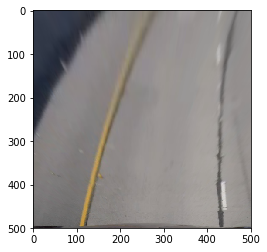

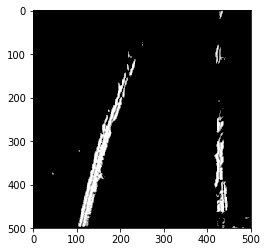

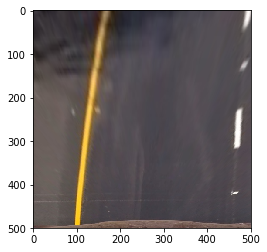

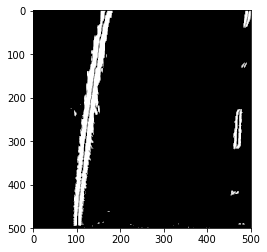

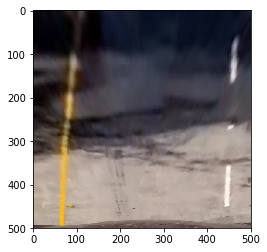

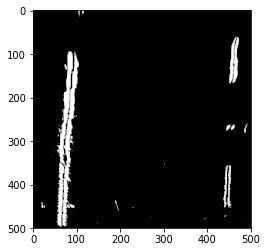

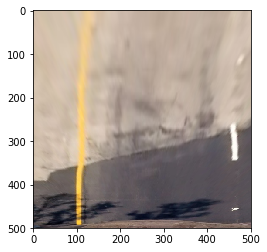

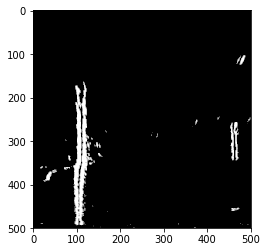

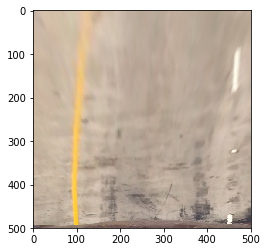

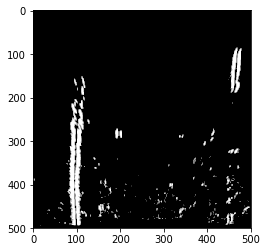

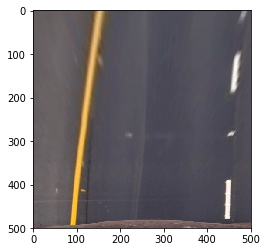

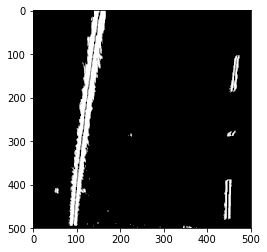

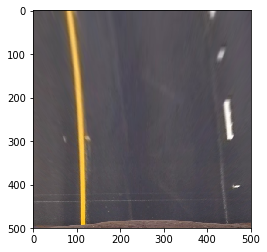

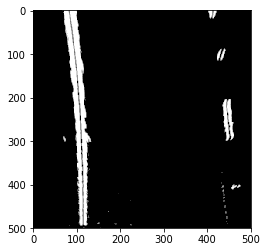

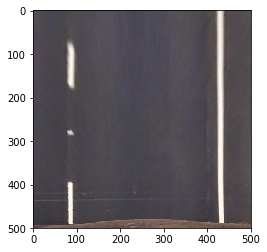

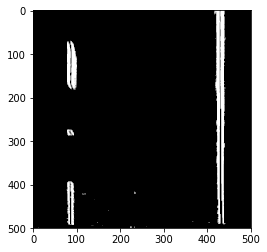

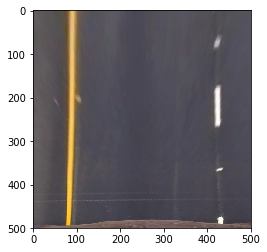

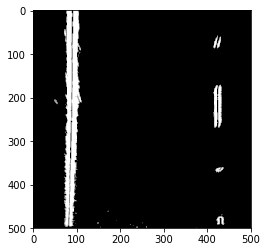

In [132]:
# combine edges and color
# def get_combined_line_pixels(img, state):
#     edges = get_binary_image_with_edge_pixels(img, state)
#     white = get_white_line_signals(img, state)
#     yellow = get_binary_image_with_color_pixels(img, state)
#     white_or_yellow = np.bitwise_or(white, yellow)
# #     display_image(edges, cmap='gray')
# #     display_image(white, cmap='gray')
# #     display_image(yellow, cmap='gray')
#     A = 0
#     B = 0
#     C = 10
    
#     conv_size = 3
#     conv_matrix = np.zeros((WARPED_HEIGHT, WARPED_WIDTH))
#     offset = int(conv_size / 2)
#     for y in range(WARPED_HEIGHT - (conv_size - 1)):
#         for x in range(WARPED_WIDTH - (conv_size - 1)):
#             edges_patch = edges[y:y + conv_size, x:x + conv_size]
#             colors_patch = white_or_yellow[y:y + conv_size, x:x + conv_size]
#             conv_matrix[y + offset, x + offset] = math.sqrt(np.sum(edges_patch) * np.sum(colors_patch))
    
#     conv_matrix = conv_matrix / (conv_size * conv_size)
# #     combined = (A * edges + B * white_or_yellow + C * edges * white_or_yellow) / (A + B + C)
# #     add_to_debug_image(combined * (255.0 / combined.max()), state)
#     add_to_debug_image(conv_matrix * 255.0, state)
#     return conv_matrix
    
# combine edges and color
def get_combined_line_pixels(img, state):
    edges = get_binary_image_with_edge_pixels(img, state)
    white = get_white_line_signals(img, state)
    yellow = get_binary_image_with_color_pixels(img, state)
    white_or_yellow = np.bitwise_or(white, yellow)
    
    conv_size = 3
    conv_matrix = np.zeros((WARPED_HEIGHT, WARPED_WIDTH))
    offset = int(conv_size / 2)
    
    edges_sum = np.zeros_like(edges)
    colors_sum = np.zeros_like(white_or_yellow)
    for i in range(conv_size):
        for j in range(conv_size):
            edges_addend = np.zeros_like(edges)
            edges_addend[0:WARPED_HEIGHT - j, 0:WARPED_WIDTH - i] = edges[j:WARPED_HEIGHT, i:WARPED_WIDTH]
            edges_sum += edges_addend
            colors_addend = np.zeros_like(white_or_yellow)
            colors_addend[0:WARPED_HEIGHT - j, 0:WARPED_WIDTH - i] = white_or_yellow[j:WARPED_HEIGHT, i:WARPED_WIDTH]
            colors_sum += colors_addend
    
    edges_sum = edges_sum[0:WARPED_HEIGHT - offset, 0:WARPED_WIDTH - offset]
    colors_sum = colors_sum[0:WARPED_HEIGHT - offset, 0:WARPED_WIDTH - offset]
    conv_matrix[offset:WARPED_HEIGHT, offset:WARPED_WIDTH] = np.sqrt(edges_sum * colors_sum)
    conv_matrix = conv_matrix / (conv_size * conv_size)
    
    add_to_debug_image(np.stack((yellow, white, edges), axis=-1) * 255.0, state)
    add_to_debug_image(conv_matrix * 255.0, state)
    return conv_matrix    
    
def test_get_combined_line_pixels(file_name):
    img = read_image("./test_images/" + file_name)
    state = get_test_state()
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    if (file_name.startswith('img_from_video_0')):
        img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
    display_image(img_warped)
    binary_image = get_combined_line_pixels(img_warped, state)
    display_image(binary_image, cmap='gray')
    
# Test
# 
files = os.listdir("./test_images")
for i, file_name in enumerate(files):
    if (file_name.endswith(".jpg")):
        print(file_name)
        test_get_combined_line_pixels(file_name)

Line detection
-----------------

In [140]:
def get_conv_kernel(width):
    conv_kernel_width = int(width * 0.08)
    conv_kernel_width = conv_kernel_width + (conv_kernel_width % 2) + 1 # make it odd
    conv_kernel_midpoint = int(conv_kernel_width / 2.0)
    OFFSET = 100
    conv_kernel = np.concatenate((
        range(OFFSET, OFFSET + conv_kernel_midpoint), 
        range(OFFSET + conv_kernel_midpoint, OFFSET - 1, -1)
    ))
    return conv_kernel

def find_peak(img_patch, conv_kernel):
    if (img_patch.shape[1] == 0):
        return 0, 0
    sum_array = np.sum(img_patch, axis=0)
#     norm_array = sum_array / (np.sum(sum_array) + 1)
    convolved_array = np.convolve(sum_array, conv_kernel, mode='same')
    offsets = np.absolute(np.arange(convolved_array.shape[0]) - (convolved_array.shape[0] / 2))
    inertia_subtrahen = offsets * 10
    inertia_multiplier = np.power(0.98, offsets)
#     print("inertia:   " + str(inertia))
#     print("convolved: " + str(convolved_array + inertia))
    values = (convolved_array * inertia_multiplier) - inertia_subtrahen
#     print("len: " + str(len(values)))
#     print("convolved_array: " + str(convolved_array))
#     print("inertia_subtrahen: " + str(inertia_subtrahen))
#     print("inertia_multiplier: " + str(inertia_multiplier))
#     print("values: " + str(values))
#     print("")
    peak = np.argmax(values)
#     print("peak:      " + str(peak))
    return peak, sum_array.sum()

def draw_window(window, state):
    offset = int((WARPED_WIDTH+DEBUG_DIVIDER_WIDTH) * 3)
    color = (0,255,0) if (window['weight'] >= MIN_WEIGHT) else (255,0,0)
    state.debug_image = cv2.rectangle(
        state.debug_image, 
        (offset + window['left'], window['top']), 
        (offset + window['right'], window['bottom']), 
        color, 
        thickness=2
    )

def constraint(value, min_value, max_value):
    return max(min(value, max_value - 1), min_value)
    
def find_initial_window_x(img_binary, side, state):
    height = img_binary.shape[0]
    width = img_binary.shape[1]
    y_point = int(height / 4)
    x_midpoint = int(width / 2)

    x_offset = x_midpoint if side == 'right' else 0 
    x_start = 0 + x_offset
    x_end = x_midpoint + x_offset

    peak, _ = find_peak(img_binary[-y_point:, x_start:x_end], state.conv_kernel)
    
    peak += x_offset
    return peak
    
SEARCH_WIDTH = WINDOW_WIDTH * 2
HALF_SEARCH_WIDTH = int(SEARCH_WIDTH / 2)
MAX_SHIFT = WINDOW_WIDTH * 0.75

def find_next_window(img_binary, prev_x, i, state):
    bottom = WARPED_HEIGHT - i * WINDOW_HEIGHT
    top = max(0, (bottom - WINDOW_HEIGHT))
    left = int(prev_x - HALF_SEARCH_WIDTH)
    right = int(prev_x + HALF_SEARCH_WIDTH)
    search_zone = img_binary[top:bottom, left:right]
    
    peak, weight = find_peak(search_zone, state.conv_kernel)
#     print("i = " + str(i) + ", weight = " + str(weight))
#     if (weight > MIN_WEIGHT):
    new_x_center = left + peak
    shift = constraint(new_x_center - prev_x, -MAX_SHIFT, MAX_SHIFT)
    new_x_center = prev_x + shift
#     else:
#         new_x_center = prev_x
    
    window = {
        'left': int(constraint(new_x_center - HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'right': int(constraint(new_x_center + HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'top': int(WARPED_HEIGHT - (i + 1) * WINDOW_HEIGHT),
        'bottom': int(WARPED_HEIGHT - i * WINDOW_HEIGHT),
        'weight': weight,
    }
    return (window, new_x_center)

MIN_DISTANCE_BETWEEN_LINES = 200
def find_window_from_curve(img_binary, i, side, state):
    bottom = WARPED_HEIGHT - i * WINDOW_HEIGHT
    top = max(0, (bottom - WINDOW_HEIGHT))
    
    y_arr = np.arange(top, bottom)
    curve = state.curves[side]
    x_arr = y_arr * y_arr * curve.a + y_arr * curve.b + curve.c
    x_curve_average = constraint(int(np.mean(x_arr)), 0, WARPED_WIDTH)

    prev_window = state.windows[side][i]
    prev_x_center = (prev_window['left'] + prev_window['right']) / 2
    if (side == 'left'):
        other_side_window = state.windows['right'][i]
        other_side_center = (other_side_window['left'] + other_side_window['right']) / 2
        x_curve_average = constraint(x_curve_average, 0, other_side_center - MIN_DISTANCE_BETWEEN_LINES)
    elif (side == 'right'):
        other_side_window = state.windows['left'][i]
        other_side_center = (other_side_window['left'] + other_side_window['right']) / 2
        x_curve_average = constraint(x_curve_average, other_side_center + MIN_DISTANCE_BETWEEN_LINES, WARPED_WIDTH)

    x_curve_average = constraint(x_curve_average, prev_x_center - MAX_SHIFT, prev_x_center + MAX_SHIFT)        
    x_curve_average = int(constraint(x_curve_average, 0, WARPED_WIDTH))
    if (i > 0):
        prev_below_x_center = (state.windows[side][i-1]['left'] + state.windows[side][i-1]['right']) / 2
        x_curve_average = int(constraint(x_curve_average, prev_below_x_center - MAX_SHIFT, prev_below_x_center + MAX_SHIFT))
    
    left = constraint(x_curve_average - HALF_SEARCH_WIDTH, 0, WARPED_WIDTH)
    right = constraint(x_curve_average + HALF_SEARCH_WIDTH, 0, WARPED_WIDTH)
    search_zone = img_binary[top:bottom, left:right]
    
    peak, weight = find_peak(search_zone, state.conv_kernel)
    if (weight > MIN_WEIGHT):
        new_x_center = left + peak
        shift = constraint(new_x_center - x_curve_average, -MAX_SHIFT, MAX_SHIFT)
        new_x_center = x_curve_average + shift
    else:
        new_x_center = x_curve_average        
    

    window = {
        'left': int(constraint(new_x_center - HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'right': int(constraint(new_x_center + HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'top': int(WARPED_HEIGHT - (i + 1) * WINDOW_HEIGHT),
        'bottom': int(WARPED_HEIGHT - i * WINDOW_HEIGHT),
        'weight': weight,
    }
    return window



In [141]:
def get_windows_for_side(img_binary, side, state):
    windows = []
    if state.curves[side] is None:
        current_x = find_initial_window_x(img_binary, side, state)
        for i in range(0, WINDOWS_N):
            window, current_x = find_next_window(img_binary, current_x, i, state)
            windows.append(window)
    else:
        for i in range(0, WINDOWS_N):
            window = find_window_from_curve(img_binary, i, side, state)
            windows.append(window)

    for window in windows:
        draw_window(window, state)
    
    return windows

def get_windows(img_binary, state):
    windows_debug_start_x = int((WARPED_WIDTH+DEBUG_DIVIDER_WIDTH) * 3)
    state.debug_image[0:WARPED_HEIGHT, windows_debug_start_x:windows_debug_start_x + WARPED_WIDTH] = 0

    windows = { 'left': [], 'right': [] }
    windows['left'] = get_windows_for_side(img_binary, 'left', state)
    windows['right'] = get_windows_for_side(img_binary, 'right', state)
    
    return windows
    
#     for i in range(0, WINDOWS_N):
#         current_left_x = find_next_window(img_binary, current_left_x, conv_kernel, i)
#         img_windows = draw_window(img_windows, current_left_x, i)    
#         current_right_x = find_next_window(img_binary, current_right_x, conv_kernel, i)
#         img_windows = draw_window(img_windows, current_right_x, i)     

Curvature
-----------

In [146]:
MIN_WEIGHT = 100
def get_curve(img_binary, windows_for_side, side, state):
    points_x = []
    points_y = []
    weight = 0
    valid_windows_count = 0
    for _, window in enumerate(windows_for_side):
        if (window['weight'] < MIN_WEIGHT):
            continue
        else:
            valid_windows_count += 1
        pixels_in_window = img_binary[window['top']:window['bottom'], window['left']:window['right']].copy()
        pixels_array = pixels_in_window.reshape(-1)
        window_width = window['right'] - window['left']
        window_height = window['bottom'] - window['top']
        indexes = np.arange(pixels_array.shape[0])
        active_indexes = indexes[pixels_array > 0]
        for _, v in enumerate(active_indexes):
            x = window['left'] + (v % window_width)
            y = window['top'] + int((v - (v % window_width)) / window_width)
            for k in range(int(max(img_binary[y,x], 0))):
                points_x.append(x)
                points_y.append(y)
            weight += img_binary[y,x]
    if (valid_windows_count >= 3):
        coeffs = np.polyfit(x=points_y, y=points_x, deg=2)
        curve = Curve(coeffs, weight)
    else:
        if (not state.curves[side] is None):
            curve = copy.copy(state.curves[side])
            curve.weight = 0
        else:
            curve = None
    state.curve_points_num[side] = len(points_y)
    return curve

X_MESHGRID, _ = np.meshgrid(range(WARPED_WIDTH), range(WARPED_HEIGHT))
def get_curves(img_binary, state):
    windows = state.windows
    left_curve = get_curve(img_binary, windows['left'], 'left', state)
    right_curve = get_curve(img_binary, windows['right'], 'right', state)
    
#     left_a0 = left_coeffs[0]
#     left_a1 = left_coeffs[1]
#     left_weight = left_coeffs[3]
#     right_a0 = right_coeffs[0]
#     right_a1 = right_coeffs[1]
#     right_weight = right_coeffs[3]
    
#     print("a0: " + str(left_a0) + " " + str(right_a0) + " " + str(left_weight) + " " + str(right_weight))
#     q = 0.1
#     left_coeffs[0] = (left_a0*left_weight + right_a0*right_weight * q) / (left_weight + right_weight * q)
#     right_coeffs[0] = (left_a0*left_weight * q + right_a0*right_weight) / (left_weight * q + right_weight)
    
#     left_coeffs[1] = (left_a1*left_weight + right_a1*right_weight/2) / (left_weight + right_weight/2)
#     right_coeffs[1] = (left_a1*left_weight/2 + right_a1*right_weight) / (left_weight/2 + right_weight)
    
#     print("a1: " + str(left_a1) + " " + str(right_a1) + " " + str(left_weight) + " " + str(right_weight))
    
        
#     img_binary_with_windows_test = img_binary.copy()
#     for i, window in enumerate(np.concatenate((windows['left'], windows['right']))):
#         img_binary_with_windows_test = cv2.rectangle(
#             img_binary_with_windows_test, 
#             (window['left'], window['top']), 
#             (window['right'], window['bottom']), 
#             0.7, 3
#         )
    
    return { 'left': left_curve, 'right': right_curve }
    

# can be improved with meshgrid (or not)
def draw_curve(img, curve, thickness = 15):
    if (curve is None):
        return img
    for y in range(0, WARPED_HEIGHT):
        x = int(curve.a * y**2 + curve.b * y + curve.c)
        for i in range(max(0, x - (thickness - 1)), min(WARPED_WIDTH - 1, x + (thickness - 1))):
            img[y, i, 1] = 255
    return img

def draw_lines(state):
    img = np.zeros((WARPED_HEIGHT, WARPED_WIDTH, 3))
    img = draw_curve(img, state.curves['left'])
    img = draw_curve(img, state.curves['right'])
    return img

def put_text(state, text, pos):
    x = state.width_orig + 30
    y = WARPED_HEIGHT + pos * 50
    cv2.putText(
            state.debug_image,
            text,
            (x, y), 
            cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA
        )
    
def print_stats(state):
    state.debug_image[WARPED_HEIGHT:, state.width_orig:, :] = 0
    img = np.zeros((state.height_orig, state.width_orig, 3))
#     print(str(state.curve_points_num))
    if (state.is_debug):
        put_text(state, str(state.curve_points_num['left']), pos=1)
        put_text(state, str(state.curve_points_num['right']), pos=2)
#     put_text(state, str(left_radius), pos=3)
#     put_text(state, str(right_radius), pos=4)
    return img

def combine(img_original, img_lines, img_stats, state):
    img_original = np.array(img_original, dtype=np.int32)
    img_lines = np.array(img_lines, dtype=np.int32)
    img_stats = np.array(img_stats, dtype=np.int32)
    result = cv2.addWeighted(img_original, 0.7, img_lines, 0.3, 0)
#     result = cv2.addWeighted(result, 1.0, img_stats, 0.3, 0)
    add_to_debug_image(result, state, row=1)
    return result

Pipeline
----------

In [147]:
# TODO consider building a class State that would contain current state and parameters
def print_msg(msg, state):
    if (state.debug == True):
        print(msg)
    return

def measure(t, name):
    new_t = time.perf_counter()
    perf_measurements[name] += new_t - t
    return t

perf_measurements = { 
    'state': 0, 'undistort': 0, 'warp': 0, 'get_combined_line_pixels': 0, 
    'get_windows': 0, 'get_curves': 0, 'draw_lines': 0, 'unwarp': 0, 'print_stats': 0, 
    'combine': 0}
def pipeline(img, state=None):
    t = time.perf_counter()
    if (state is None):
        state = State(img)
    state.debug_left_pos = 0
    t = measure(t, 'state')
    
    img_undistorted = undistort(img, state)
    t = measure(t, 'undistort')
    
    img_warped = warp(img_undistorted, state)
    t = measure(t, 'warp')
    
    # TODO replace binary with smth else: e.g. values can be 
    # 0(no border, no color match), 0.5(border or color), 1(border and color)
    # get_curves then would duplicate the point if it's value is 1
    img_significant_pixels = get_combined_line_pixels(img_warped, state)
#     display_image(img_significant_pixels)
    t = measure(t, 'get_combined_line_pixels')
    
    state.windows = get_windows(img_significant_pixels, state)
    t = measure(t, 'get_windows')
#     print(state.windows)
    
    state.curves = get_curves(img_significant_pixels, state)
    t = measure(t, 'get_curves')
    
    img_lines_warped = draw_lines(state)
    t = measure(t, 'draw_lines')
    
    img_lines = unwarp(img_lines_warped, state)
    t = measure(t, 'unwarp')
    
    img_stats = print_stats(state)
    t = measure(t, 'print_stats')
    # TODO leave only points with intensity above average (or above ""(top 5% - bottom5%) / 2" )
    # Consider combining lines (overlap right on left and vice versa to get more points)
    # TODO print info on the image
    output = combine(img, img_lines, img_stats, state)
    t = measure(t, 'combine')
    if (state.is_debug_video == True):
        return state.debug_image.astype(int)
    return output

img_from_video_19.jpg
img_from_video_20.jpg


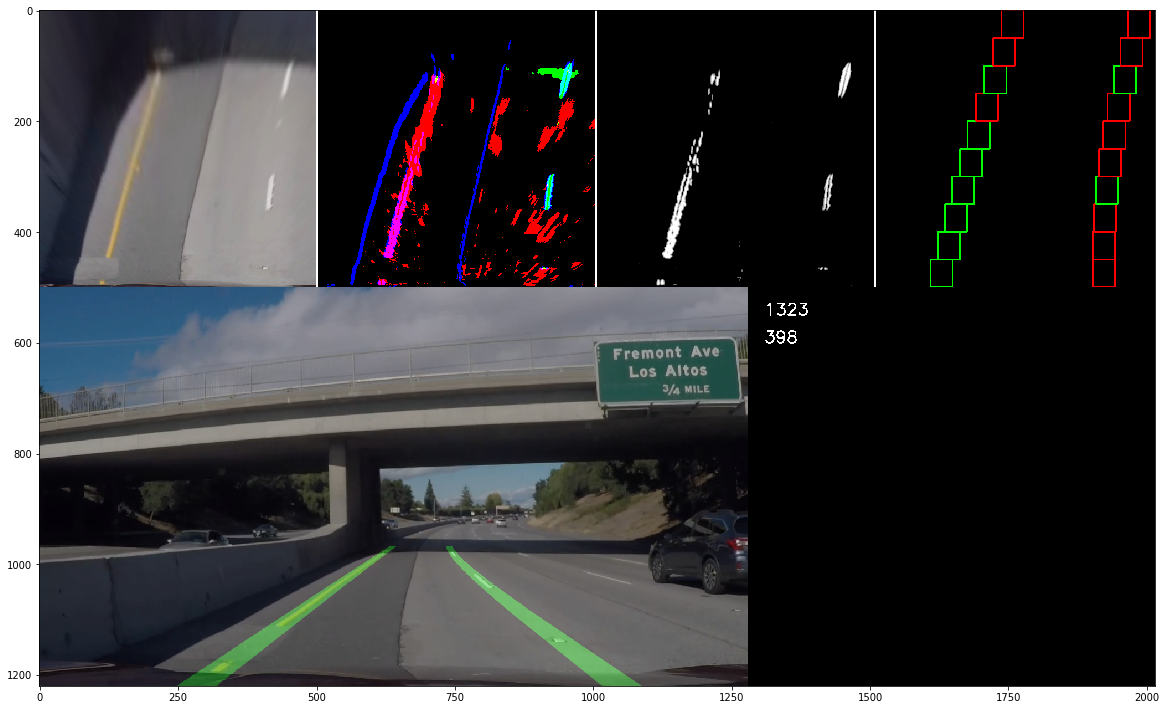

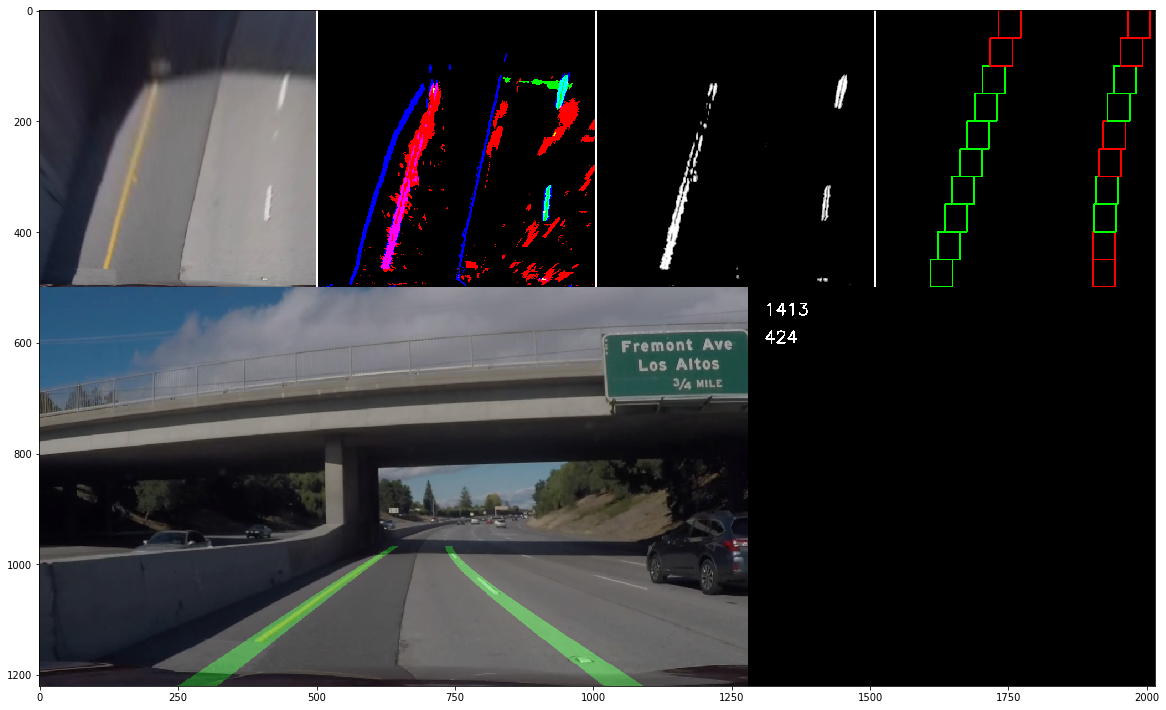

In [148]:
# test_image = read_image('test_images/test6.jpg')
state = State(test_image, True, True)
files = os.listdir("./images_from_video")
files.sort()
for i, file_name in enumerate(files):
    if (file_name.endswith(".jpg")):
        img = read_image("./images_from_video/" + file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = pipeline(img, state)
        if (i > 19 and i < 22):
            print(file_name)
            display_image(result, figsize=(20, 20))

{'warp': 2.228329912875779, 'draw_lines': 5.575704974820837, 'unwarp': 6.195324021624401, 'print_stats': 6.282085951883346, 'state': 0.00024896569084376097, 'get_combined_line_pixels': 4.230273023247719, 'get_windows': 4.3907180989626795, 'undistort': 2.064944009995088, 'get_curves': 5.054341265116818, 'combine': 10.379572882084176}


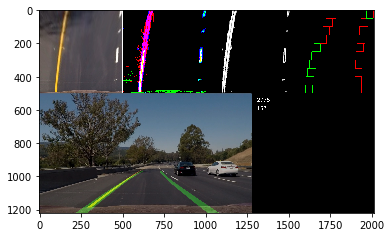

In [149]:
display_image(pipeline(test_image, state))
print(perf_measurements)

Video
-------

In [150]:
VIDEOS = ['challenge_video.mp4', 'harder_challenge_video.mp4', 'project_video.mp4']

In [151]:
video_state = None
def get_video_state(img):
    global video_state
    if (video_state is None):
        video_state = State(img, False, is_debug_video=True)
    return video_state

def process_image(img):
    return pipeline(img, get_video_state(img))

img_n = 0
def write_img(img):
    global img_n
    zero = "0" if img_n < 10 else ""
    cv2.imwrite("img_from_video_" + zero + str(img_n) + ".jpg", img)
    img_n+=1
    return img

In [152]:
def process_video(i, start=0, end=None):
    name = VIDEOS[i]
    if end is None:
        clip = VideoFileClip(name).subclip(start)
    else:
        clip = VideoFileClip(name).subclip(start, end)
    output_name = 'test_videos_output/' + name
    output_clip = clip.fl_image(process_image)
    %time output_clip.write_videofile(output_name, audio=False)
    return HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(output_name))

In [153]:
video_state = None
# process_video(2, 21, 30)
process_video(2)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [07:04<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 17min 27s, sys: 3min 4s, total: 20min 31s
Wall time: 7min 5s


In [68]:
perf_measurements'

{'combine': 712.2576431648922,
 'draw_lines': 495.02038788452046,
 'get_combined_line_pixels': 223.53187427070225,
 'get_curves': 467.2847643296118,
 'get_windows': 230.0173478766228,
 'print_stats': 523.2954102960648,
 'state': 0.008002934220712632,
 'undistort': 133.43507210013922,
 'unwarp': 521.8051249806886,
 'warp': 144.71472446783446}

In [ ]:
# TODO
# curve weight from past curves...?
# new curve = current_weight*current_curve + prev_weight????*prev_curve
# prev_weight = 


# - set minimum number of points needed for a curve (can also use it as a 'weight' of a curve)
# - use prev curve as inertia
# - smoothen curves by taking weighted average for a and b coefficients for left and right lines - 
# e.g. left_a = 0.6*left_a + 0.2*right_a * 0.2*prev_right_a
# - draw green stuff
# - see what happens when a line is out of sight